In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/appbites/Desktop/mlfs-book
HopsworksSettings initialized!


## Part 03: Training Pipeline

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [10]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
country="Austria"
city="Vienna"

2025-11-18 13:36:07,087 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 13:36:07,101 INFO: Initializing external client
2025-11-18 13:36:07,102 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 13:36:08,394 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1289364


### Get feature groups

In [11]:
# Retrieve feature groups
stations_air_quality_daily = fs.get_feature_group(
    name='stations_air_quality_daily',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [12]:
# Select features for training data.
selected_features = stations_air_quality_daily.select(['station_uid', 'pm25', 'pm25_t1', 'pm25_t2', 'pm25_t3', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-18 13:36:14,241 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Create Feature View

In [13]:
feature_view = fs.get_or_create_feature_view(
    name='stations_air_quality_fv_with_shift_window',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [14]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [15]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

### CLEAN TRAIN ###
train_df = pd.concat([X_train, y_train], axis=1)
train_df = train_df.dropna()

X_train = train_df[X_train.columns]
y_train = train_df[y_train.columns]

### CLEAN TEST ###
test_df = pd.concat([X_test, y_test], axis=1)
test_df = test_df.dropna()

X_test = test_df[X_test.columns]
y_test = test_df[y_test.columns]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.91s) 


In [16]:
X_train

,station_uid,pm25_t1,pm25_t2,pm25_t3,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2860,109.0,79.0,110.0,2014-01-04 00:00:00+00:00,4.262000,1.8,31.753550,138.866608
1,2855,113.0,85.0,112.0,2014-01-04 00:00:00+00:00,4.262000,1.8,31.753550,138.866608
2,2850,99.0,76.0,105.0,2014-01-04 00:00:00+00:00,4.262000,1.8,31.753550,138.866608
3,2855,94.0,113.0,85.0,2014-01-05 00:00:00+00:00,7.801584,2.1,24.967499,245.661194
4,2860,92.0,109.0,79.0,2014-01-05 00:00:00+00:00,7.801584,2.1,24.967499,245.661194
...,...,...,...,...,...,...,...,...,...
25957,2870,40.0,32.0,30.0,2025-04-30 00:00:00+00:00,18.760750,0.0,10.662626,348.885651
25958,2857,41.0,35.0,30.0,2025-04-30 00:00:00+00:00,18.760750,0.0,10.662626,348.885651
25959,4738,43.0,35.0,30.0,2025-04-30 00:00:00+00:00,18.760750,0.0,10.662626,348.885651
25960,2850,43.0,36.0,33.0,2025-04-30 00:00:00+00:00,18.760750,0.0,10.662626,348.885651


In [17]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

X_features

,station_uid,pm25_t1,pm25_t2,pm25_t3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2860,109.0,79.0,110.0,4.262000,1.8,31.753550,138.866608
1,2855,113.0,85.0,112.0,4.262000,1.8,31.753550,138.866608
2,2850,99.0,76.0,105.0,4.262000,1.8,31.753550,138.866608
3,2855,94.0,113.0,85.0,7.801584,2.1,24.967499,245.661194
4,2860,92.0,109.0,79.0,7.801584,2.1,24.967499,245.661194
...,...,...,...,...,...,...,...,...
25957,2870,40.0,32.0,30.0,18.760750,0.0,10.662626,348.885651
25958,2857,41.0,35.0,30.0,18.760750,0.0,10.662626,348.885651
25959,4738,43.0,35.0,30.0,18.760750,0.0,10.662626,348.885651
25960,2850,43.0,36.0,33.0,18.760750,0.0,10.662626,348.885651


In [18]:
y_train

,pm25
0,92.0
1,94.0
2,89.0
3,49.0
4,51.0
...,...
25957,27.0
25958,30.0
25959,37.0
25960,30.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [19]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 106.81062
R squared: 0.1278412567424576


In [21]:
df = y_test
df['predicted_pm25'] = y_pred

In [22]:
df['date'] = X_test['date']
df["station_uid"] = X_test["station_uid"].values
df = df.sort_values(by=['date', 'station_uid'])
df.head(5)

,pm25,predicted_pm25,date,station_uid
25969,31.0,27.602369,2025-05-01 00:00:00+00:00,2850
25964,42.0,37.884689,2025-05-01 00:00:00+00:00,2855
25967,29.0,27.810822,2025-05-01 00:00:00+00:00,2857
25965,34.0,37.981438,2025-05-01 00:00:00+00:00,2860
25968,26.0,25.595881,2025-05-01 00:00:00+00:00,2870


In [23]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "stations_air_quality_model_several_stations_with_lag"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)


 Generating hindcast for Kendlerstraße 40 (Umspannwerk) (2850)...


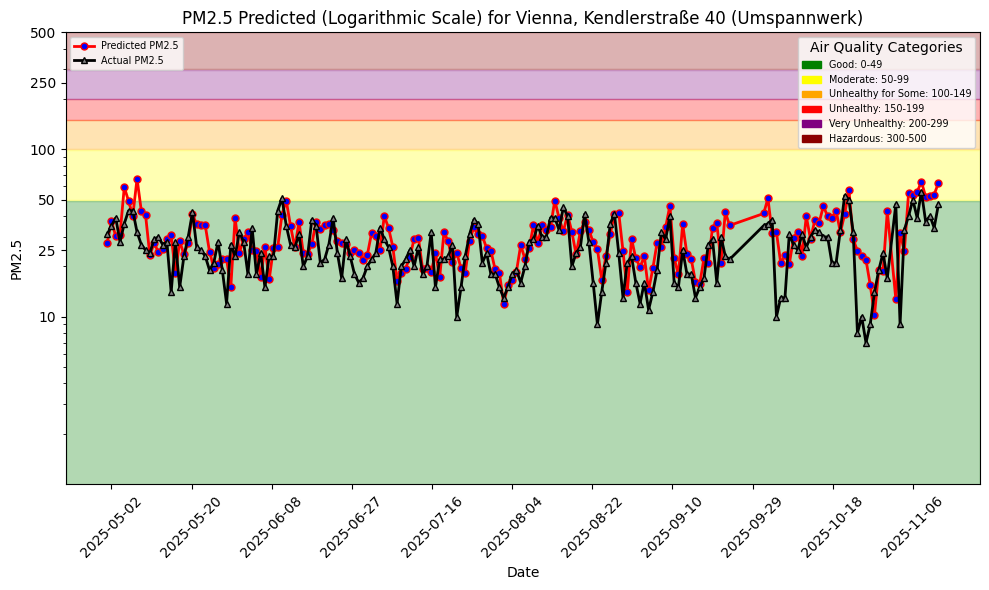

 Generating hindcast for Hausgrundweg 23, Gstr. 254 (2855)...


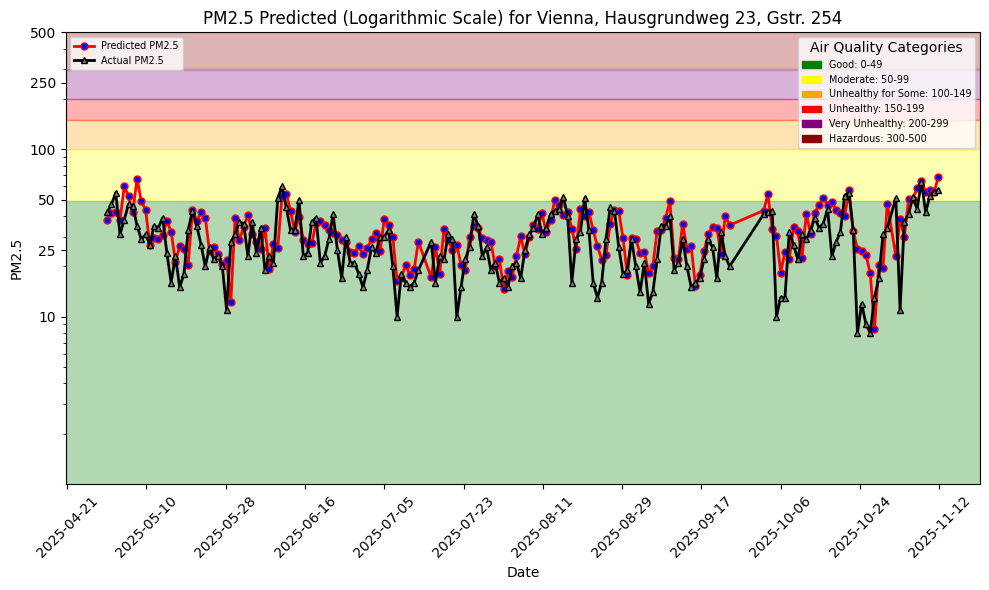

 Generating hindcast for Umspannwerk Gaudenzdorfer Gürtel (2857)...


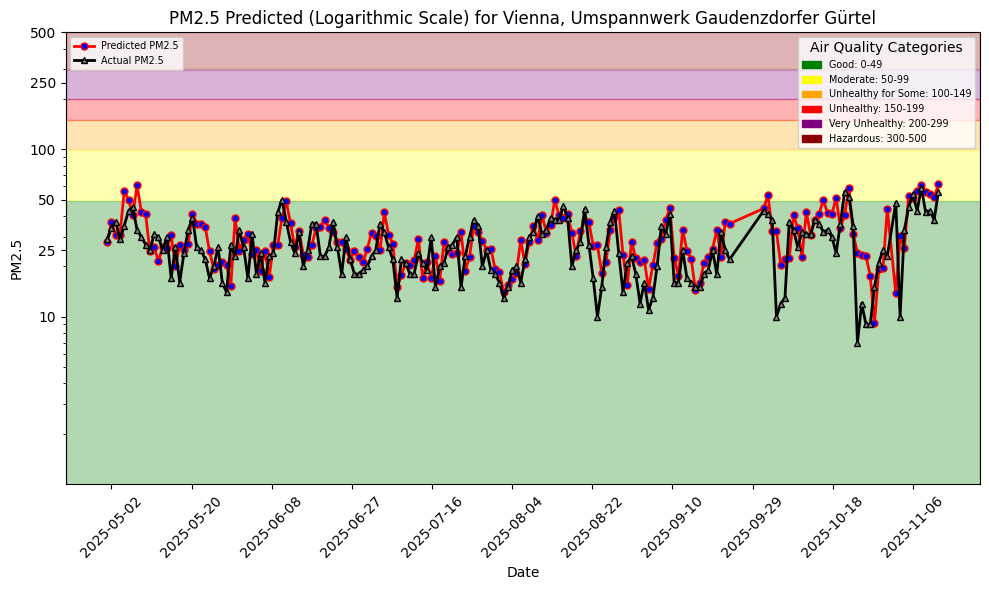

 Generating hindcast for Ecke Taborstraße - Glockengasse (2860)...


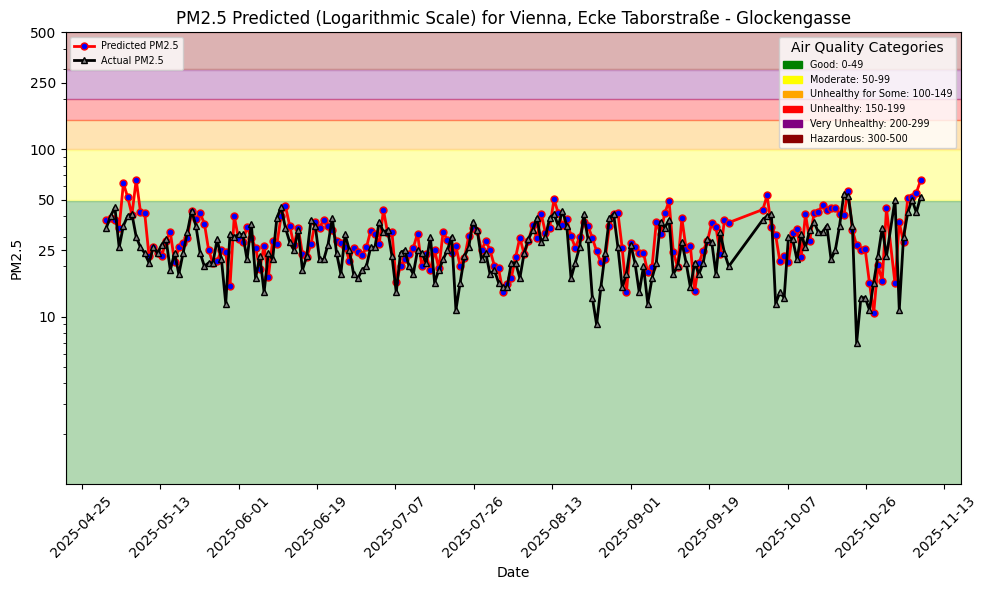

 Generating hindcast for Belgradplatz (Südostecke), Gstr.Nr. 816 (2870)...


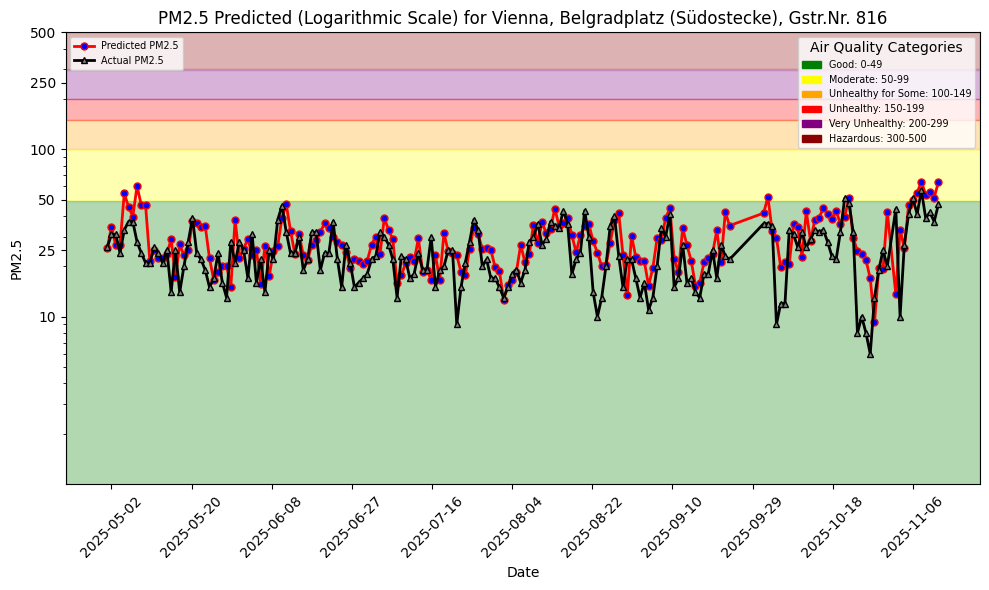

 Generating hindcast for Wehlistraße 366, Gstr.Nr.2157 (4736)...


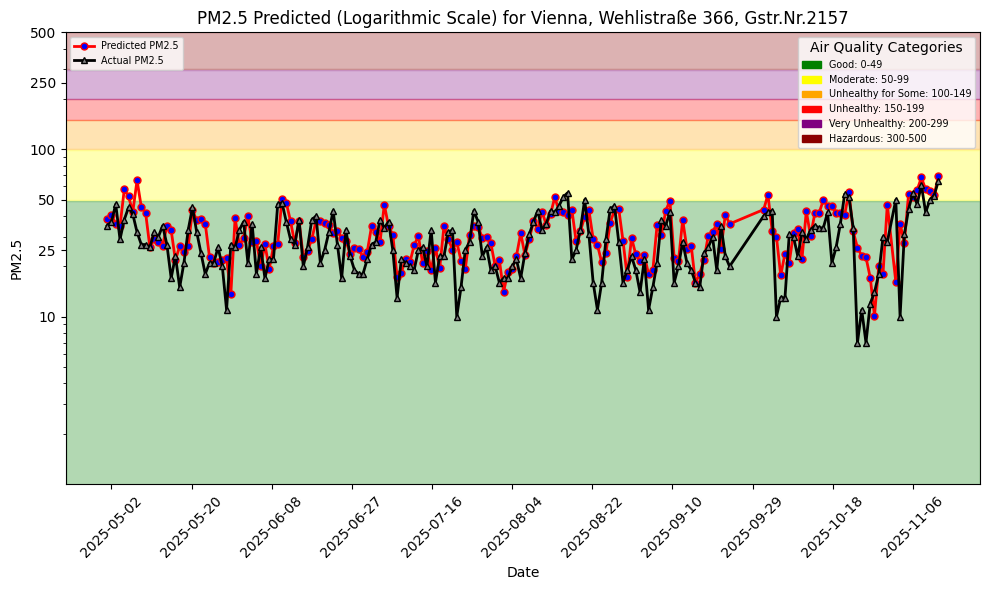

 Generating hindcast for Floridsdorf, Gerichtsgasse 1a (Prager Str. 65m) (4738)...


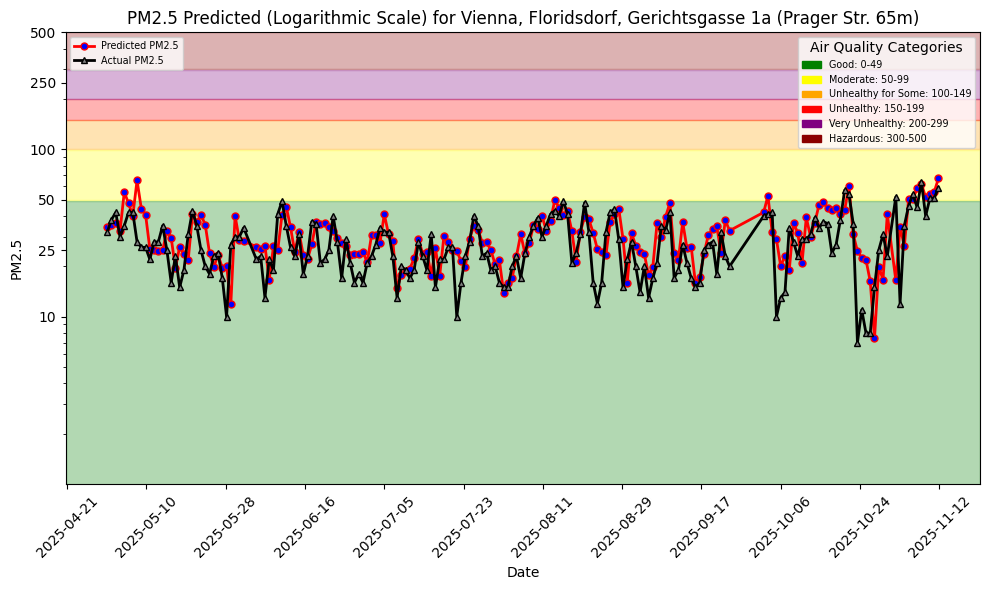

 Generating hindcast for Schafbergbad, Josef Redl Gasse 2, Gstr.Nr. 698 (4739)...


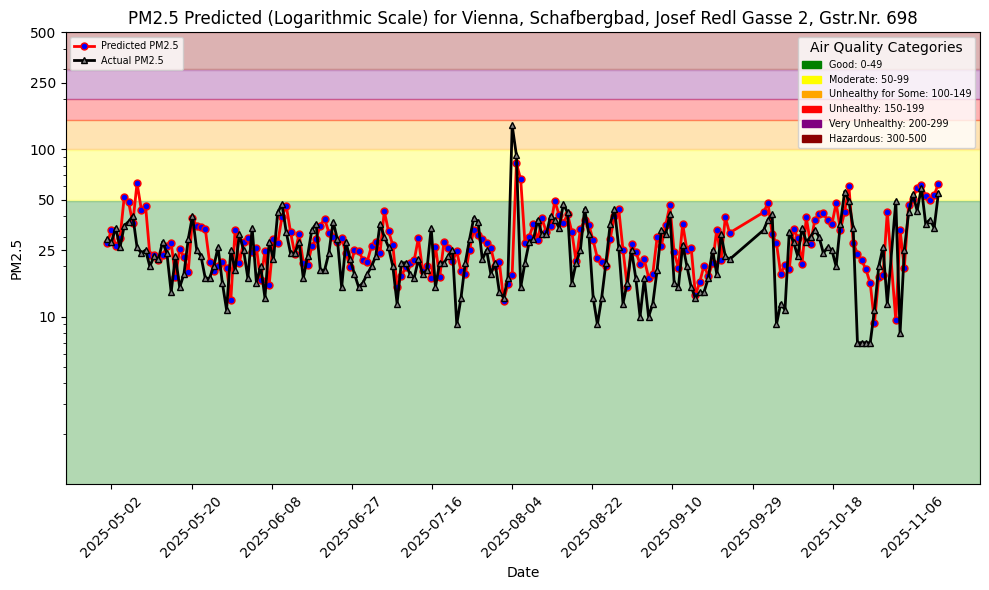

 Generating hindcast for Ostringweg (zwischen Gebäuden BT25) (14537)...


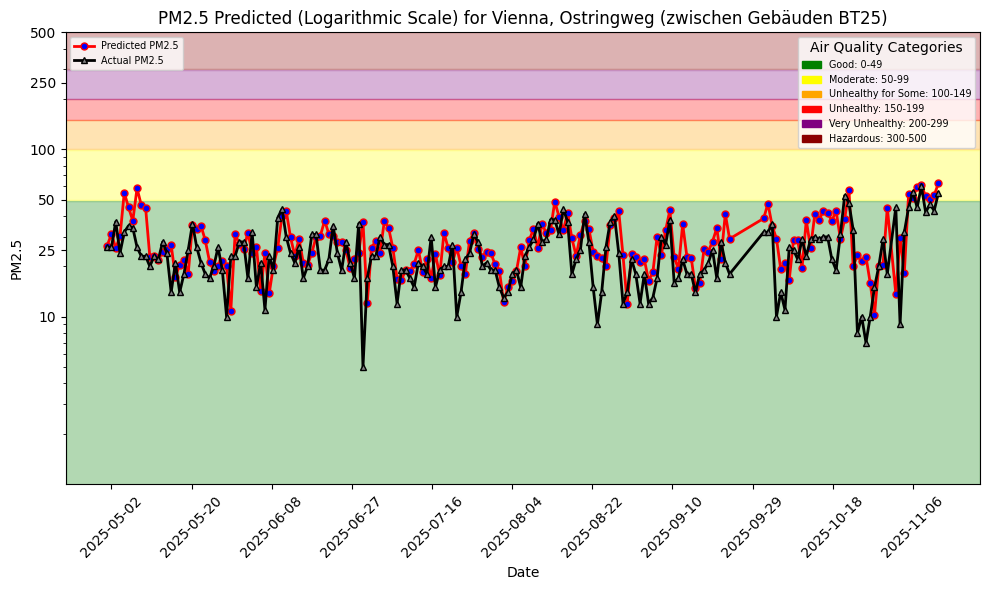

In [24]:
# Load station metadata for mapping UID → street name
stations_path = f"{root_dir}/stations.json"
with open(stations_path, "r") as f:
    stations_meta = json.load(f)
stations_map = {s["uid"]: s for s in stations_meta}

# Loop over each unique station_uid in the test set
for uid in df["station_uid"].unique():
    df_station = df[df["station_uid"] == uid].copy()
    meta = stations_map.get(int(uid), {})
    street = meta.get("street", f"station_{uid}")
    city = meta.get("city", "Vienna")

    print(f" Generating hindcast for {street} ({uid})...")

    # Save plot for this station
    file_path = os.path.join(images_dir, f"{uid}_pm25_hindcast.png")
    plt = util.plot_air_quality_forecast(city, street, df_station, file_path, hindcast=True)
    plt.show()
    plt.close()  # close after saving to free memory


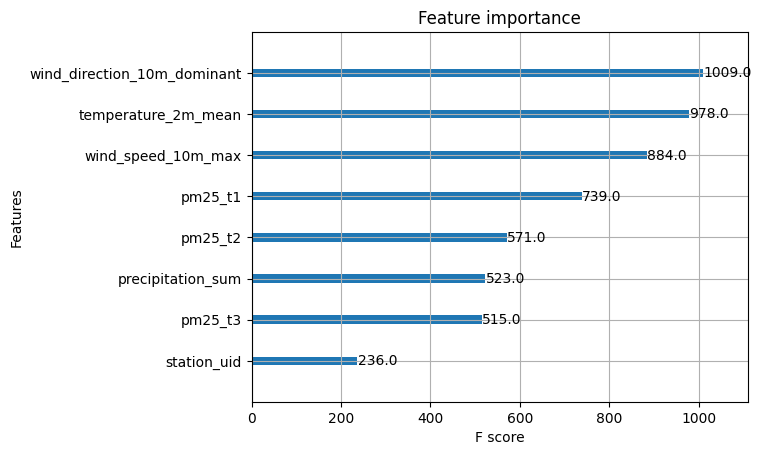

In [25]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

In [26]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [27]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [28]:
mr = project.get_model_registry()

# Creating a Python model in the model registry
aq_model = mr.python.create_model(
    name="stations_air_quality_xgboost_model_several_stations_lag",
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor for several Vienna Stations with sliding window",
)

# Saving the model artifacts to the directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/stations_air_quality_model_several_stations_w…

Uploading /Users/appbites/Desktop/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0/849 e…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1289364/models/stations_air_quality_xgboost_model_several_stations_lag/1


Model(name: 'stations_air_quality_xgboost_model_several_stations_lag', version: 1)